'#########################################\nmodel = RidgeRegression(\n    loss_fn = torch.nn.MSELoss(),\n    n_input = pd.DataFrame.to_numpy(client[0]).shape[-1],\n    l2_lambda = 0.05,\n    learning_rate = 0.05,\n)\n\n# fit model\ntrainer = pl.Trainer(max_epochs=100)\ntrainer.fit(model, dataloader_train, dataloader_test)\n\nw_model = np.append(\n    model.output_layer.bias.detach().numpy()[0],\n    model.output_layer.weight.detach().numpy(),\n)\n\nplot_convergence(model.train_log)\n'

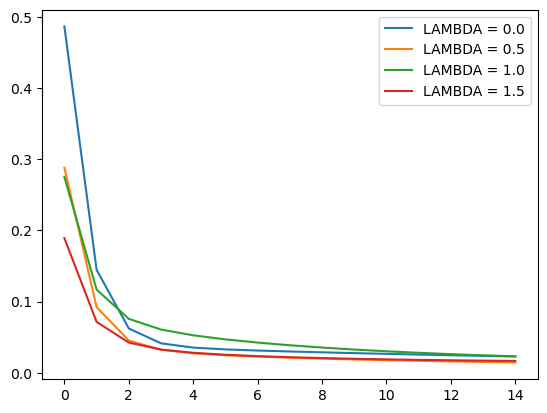

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

class FedLearningDataLoader(object):
    #Loading one building data//min-max regularization//shuffling
    def __init__(self, obj_data):
        self.data = obj_data
        self.data.isnull().sum().sum()
        self.data = self.data.dropna()
        colnames = self.data.columns
        MS = MinMaxScaler()
        self.data = MS.fit_transform(self.data)
        data = pd.DataFrame(self.data, columns=colnames)
        data = shuffle(data)
        self.x_data = data.iloc[:, :-1]
        self.y_data = data.iloc[:, [-1]]
    
    #Splitting data by the number of client//training(80%) and test(20%)
    def client_data_partition(self, num):
        client = [];client_ans = [];client_test =[];client_ans_test=[]
        
        split_loc = len(self.x_data)//num
        for i in range(num):
            temp_x = self.x_data.iloc[split_loc*i:split_loc*(i+1), :]
            temp_y = self.y_data.iloc[split_loc*i:split_loc*(i+1), :]
            
            client.append(temp_x.iloc[:int(len(temp_x)*0.8), :])
            client_ans.append(temp_y.iloc[:int(len(temp_y)*0.8), :])
            client_test.append(temp_x.iloc[int(len(temp_x)*0.8):, :])
            client_ans_test.append(temp_y.iloc[int(len(temp_y)*0.8):, :])

        return client, client_ans, client_test, client_ans_test
    
class FL_Ridge(object):
    def __init__(self, in_features, out_features, num_client, learning_rate, LAMBDA):
        self.models = []
        self.optimizers = []
        self.num_client = num_client
        for i_client in range(num_client):
            self.models.append(
                nn.ModuleList([
                    nn.Linear(in_features = in_features, out_features = out_features, bias = False)
                ])
            )
            #self.optimizers.append(torch.optim.Adam(params=self.models[i_client].parameters(), lr=learning_rate))
            self.optimizers.append(torch.optim.SGD(params=self.models[i_client].parameters(), lr=learning_rate, weight_decay=LAMBDA))
            
        #Add L2_reg later 
        self.loss_function = nn.MSELoss()
           
    def train_client(self, i_client, client, client_ans, iteration):
        #calculate ith client part w.r.t current weight and bias
        x=[];yyy=[]
        for step in range(iteration):
            batch_train = torch.from_numpy(pd.DataFrame.to_numpy(client[i_client], dtype=np.float32))
            index_target = pd.DataFrame.to_numpy(client_ans[i_client], dtype=np.float32)
            
            batch_train.requires_grad = True
            self.optimizers[i_client].zero_grad()
            y = batch_train

            for layer in self.models[i_client]:
                y = layer(y)        

            target = torch.from_numpy(index_target)

            loss = self.loss_function(y, target)
            loss.backward()
            
            # check gradients
            for layer in self.models[i_client]:
                grads = [p.grad for p in layer.parameters()]
                param = [p for p in layer.parameters()]
            self.optimizers[i_client].step()

            x.append(step)
            yyy.append(loss.item())
            
        loss = loss.detach().numpy()
        return loss, x, yyy
    
########################################################
#From this, the main code starts
########################################################
data = pd.read_csv('C:/Research/cowork/ISE_537_CA_OneBuilding_Part_1.csv')
FLDataset = FedLearningDataLoader(data)

#data partitioning <- the number of client is three
(client, client_ans, client_test, client_ans_test) = FLDataset.client_data_partition(1)

in_features = pd.DataFrame.to_numpy(client[0]).shape[-1]; out_features = 1
num_client = 1; learning_rate = 0.05; #LAMBDA = 3

for i in range(4):
    LAMBDA = i*0.5
    FLRidge = FL_Ridge(in_features, out_features, num_client, learning_rate, LAMBDA)
    (loss, x, yyy) = FLRidge.train_client(0, client, client_ans, 15)
    plt.plot(x, yyy, label = 'LAMBDA = '+str(LAMBDA))
    plt.legend()


'''#########################################
model = RidgeRegression(
    loss_fn = torch.nn.MSELoss(),
    n_input = pd.DataFrame.to_numpy(client[0]).shape[-1],
    l2_lambda = 0.05,
    learning_rate = 0.05,
)

# fit model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader_train, dataloader_test)

w_model = np.append(
    model.output_layer.bias.detach().numpy()[0],
    model.output_layer.weight.detach().numpy(),
)

plot_convergence(model.train_log)
'''